In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split


In [2]:
# Settings:
pd.set_option('display.width', 190)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('max_colwidth', 200)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('default')
np.set_printoptions(threshold = 30, edgeitems = 30, precision = 2, suppress = False)


In [3]:
df_path = "BCI_fixed.csv"
features = ["BCI", "BCIp", "BCIg"]
model_names = ["Logistic Regression", "Penalized SVM", "Random Forest"]
get_models = [lambda: linear_model.LogisticRegression(), lambda: svm.SVC(kernel='linear', class_weight='balanced', probability=True), 
          lambda: RandomForestClassifier()]


In [4]:
# Read the data and do a little bit of wrangling:
df = pd.read_csv(df_path)
df.Date = pd.to_datetime(df.Date)
df = df.sort_values(ascending=True, by="Date")
df = df.set_index("Date")

In [5]:
# Split into training and test sets and hold out the test set until the end, so that it remains "unseen".
lag_of_y = 21 # This is the lag we introduce to the target variable so that we assess the indicator's 
              # ability to predict the target variable this many steps into the future.
              # With BCI, a lag of 21 data points corresponds to about half a year.
        
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:-lag_of_y, df.columns != "USRECD"], \
    df.iloc[lag_of_y:, df.columns == "USRECD"], test_size=0.1, shuffle=False)

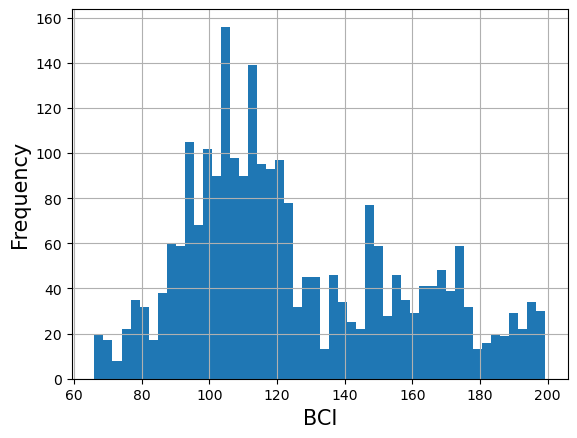

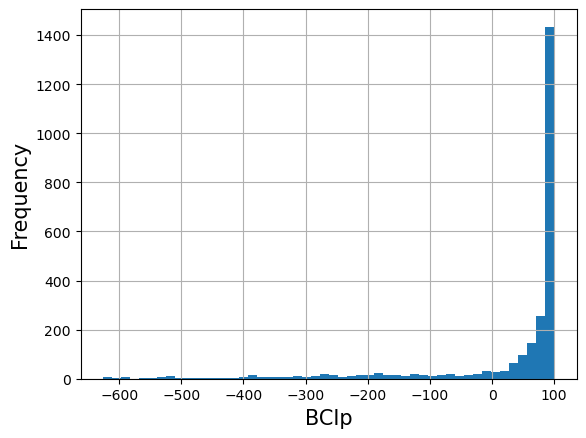

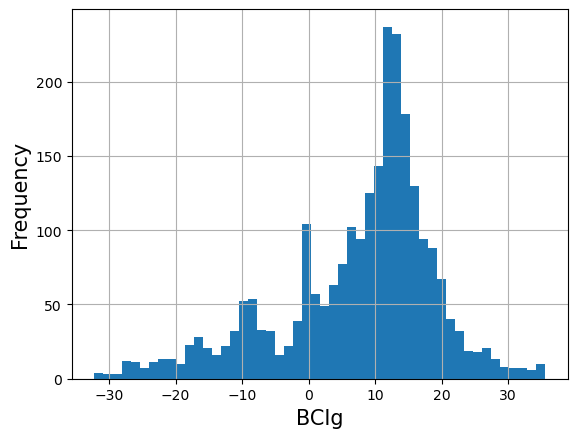

In [6]:
for feature in features:
    plt.figure()
    X_train[feature].hist(bins = 50)
    plt.xlabel(feature,fontsize=15)
    plt.ylabel("Frequency",fontsize=15)
    plt.show()

In [7]:
# Do a time series cross-validation on the test set by splitting it to k folds and doing a "rolling"
# validation against a validation fold, then averaging out the metrics.
splits = 4 # This is the number of splits/folds in the rolling validation.
tscv = TimeSeriesSplit(n_splits=splits)

for train_index, test_index in tscv.split(X_train): # Rolling cross-validation happens inside this loop.
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29 ... 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501] TEST: [ 502  503  504  505  506  507  508  509  510  511  512  513  514  515
  516  517  518  519  520  521  522  523  524  525  526  527  528  529
  530  531 ...  971  972  973  974  975  976  977  978  979  980  981  982
  983  984  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000]
TRAIN: [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29 ...  971  972  973  974  975  976  977  978  979  980  981  982
  983  984  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000] TEST: [1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014
 1015 1016 1017 1018 1019 1020 102

## Validation

In [8]:
AUC_ROCs = dict()
ACCs = dict()
for model_name, get_model in zip(model_names, get_models):
    print(model_name)
    AUC_ROCs[model_name] = 0
    ACCs[model_name] = 0
    for train_index, test_index in tscv.split(X_train): # Rolling cross-validation happens inside this loop.
        X_train_fold, X_validation_fold = X_train.iloc[train_index[:-lag_of_y], X_train.columns != "USRECD"], \
            X_train.iloc[test_index[:-lag_of_y], X_train.columns != "USRECD"]
        y_train_fold, y_validation_fold = y_train.iloc[train_index[lag_of_y:], y_train.columns == "USRECD"], \
            y_train.iloc[test_index[lag_of_y:], y_train.columns == "USRECD"]
            
        scalers = dict()
        for feature in features:
            scalers[feature] = StandardScaler()
            scalers[feature].fit(X_train_fold[[feature]])
            X_train_fold[feature] = scalers[feature].transform(X_train_fold[[feature]])
            X_validation_fold[feature] = scalers[feature].transform(X_validation_fold[[feature]])
            
        model = get_model()
        model.fit(X_train_fold, y_train_fold["USRECD"])
        positive_probs = [p[1] for p in model.predict_proba(X_validation_fold)]
        AUC_ROC = metrics.roc_auc_score(y_validation_fold, positive_probs)
        AUC_ROCs[model_name] += AUC_ROC
        predictions = model.predict(X_validation_fold)
        ACC = accuracy_score(y_validation_fold, predictions)
        ACCs[model_name] += ACC
        print(AUC_ROC, ACC)
        
    AUC_ROCs[model_name] /= splits
    ACCs[model_name] /= splits

Logistic Regression
0.5882116004296455 0.8179916317991632
0.8714177978883861 0.7217573221757322
0.926926797807159 0.20920502092050208
0.8574358974358974 0.8263598326359832
Penalized SVM
0.5943877551020409 0.7552301255230126
0.8992898441427853 0.3410041841004184
0.8839084166397937 0.07322175732217573
0.8602884615384615 0.7217573221757322
Random Forest
0.7700187969924812 0.7803347280334728
0.8953619909502262 0.6150627615062761
0.8236697839406644 0.8347280334728033
0.8141025641025641 0.8075313807531381


In [9]:
for model_name in model_names:
    print(model_name)
    print(f"AUC ROC: {AUC_ROCs[model_name]}")
    print(f"accuracy: {ACCs[model_name]}")

Logistic Regression
AUC ROC: 0.8109980233902719
accuracy: 0.6438284518828452
Penalized SVM
AUC ROC: 0.8094686193557703
accuracy: 0.4728033472803347
Random Forest
AUC ROC: 0.8257882839964839
accuracy: 0.7594142259414227


## Test

In [10]:
# random guess
total = y_train.shape[0]
metrics.roc_auc_score(y_train.USRECD, np.zeros(total)), accuracy_score(y_train.USRECD, np.zeros(total))

(0.5, 0.8538831064851882)

In [11]:
X_train = X_train.copy()
X_test = X_test.copy()

all_scalers = dict()
for feature in features:
    all_scalers[feature] = StandardScaler()
    all_scalers[feature].fit(X_train[[feature]])
    X_train[feature] = all_scalers[feature].transform(X_train[[feature]])
    X_test[feature] = all_scalers[feature].transform(X_test[[feature]])

In [12]:
for feature in features:
    print(all_scalers[feature].mean_)

[125.27]
[32.24]
[7.56]


In [16]:
for model_name, get_model in zip(model_names, get_models):
    print(model_name)
    model = get_model()
    model.fit(X_train, y_train["USRECD"])
    positive_probs = [p[1] for p in model.predict_proba(X_test)]
    AUC_ROC = metrics.roc_auc_score(y_test, positive_probs)
    print(AUC_ROC)
    predictions = model.predict(X_test)
    ACC = accuracy_score(y_test, predictions)
    print(ACC)

Logistic Regression
0.9728260869565217
0.9928057553956835
Penalized SVM
0.9692028985507246
0.9928057553956835
Random Forest
0.411231884057971
0.9928057553956835
